In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from tqdm.notebook import trange
from sklearn.model_selection import train_test_split

## EDA and Data Cleaning


You can load data bu this link: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset

In [2]:
data = pd.read_csv(r'C:\EMOJI\ratings_small.csv')
data

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [3]:
data.movieId.nunique()

9066

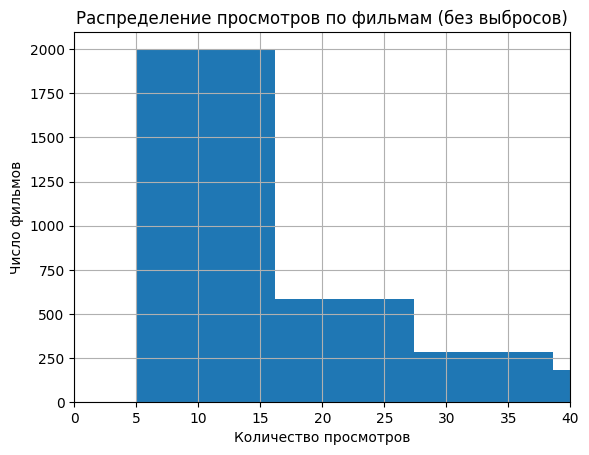

In [4]:
movie_counts = data.groupby("movieId").count()["userId"]
filtered_movies = movie_counts[movie_counts >= 5]

filtered_movies.hist(bins=30)
plt.xlabel('Количество просмотров')
plt.ylabel('Число фильмов')
plt.xlim(0, 40)
plt.title('Распределение просмотров по фильмам (без выбросов)')
plt.show()

Возьмем небольшую подвыборку фильмов, которые смотрят чаще всего

In [5]:
movie_counts = data.groupby("movieId").count()["userId"]
valid_movie_ids = movie_counts[movie_counts >= 25].index
filtered_data = data[data["movieId"].isin(valid_movie_ids)]
filtered_data

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99995,671,5989,4.0,1064890625
99996,671,5991,4.5,1064245387
99997,671,5995,4.0,1066793014
100001,671,6365,4.0,1070940363


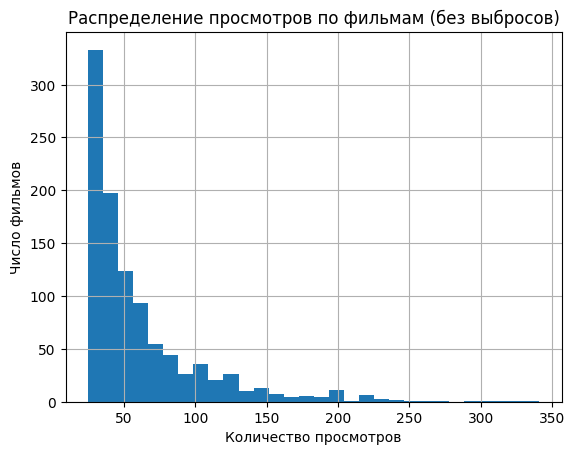

In [6]:
movie_counts = filtered_data.groupby("movieId").count()["userId"]
filtered_movies = movie_counts[movie_counts >= 5]

filtered_movies.hist(bins=30)
plt.xlabel('Количество просмотров')
plt.ylabel('Число фильмов')
plt.title('Распределение просмотров по фильмам (без выбросов)')
plt.show()

In [7]:
filtered_data.movieId.nunique()

1029

## Подготовка данных для обучения

In [8]:
data_matrix = filtered_data.pivot(index='movieId', columns ='userId', values ='rating').fillna(0)
data_matrix

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,...,0.0,4.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,5.0,4.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
122882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
interactions_count = data_matrix.astype("bool").sum().sum()

In [10]:
X = torch.zeros(len(data_matrix.index)+len(data_matrix.columns), len(data_matrix.index))
Y = torch.zeros(interactions_count)
pad = torch.zeros(len(data_matrix.index)-len(data_matrix.columns))
edge_index = torch.zeros(2*interactions_count, 2)
k =0
for i in range(len(data_matrix.columns)):
    X[k] = torch.tensor(data_matrix.iloc[:, i].values)
    k+=1
for j in range(len(data_matrix.index)):
    X[k] = torch.cat((torch.tensor(data_matrix.iloc[j,:].values), pad))
    k+=1
X.shape

torch.Size([1700, 1029])

In [11]:
k = 0
for i in range(len(data_matrix.columns)):
    for j in range(len(data_matrix.index)):
        if data_matrix.iloc[j, i]!=0:
            Y[k] = torch.tensor(data_matrix.iloc[j, i])
            edge_index[2*k] = torch.tensor([i, len(data_matrix.columns)+j-1])
            edge_index[2*k+1] = torch.tensor([len(data_matrix.columns)+j-1, i])
            k+=1
            
    if i%100 == 0:
        print(i)

0
100
200
300
400
500
600


In [12]:
x_tr, x_te, y_tr, y_te  = train_test_split(edge_index[::2], Y)

In [13]:
edge_index_train = torch.zeros(x_tr.shape[0]*2, 2)
for i, el in enumerate(x_tr):
    edge_index_train[2*i] = el
    el[0], el[1] = el[1], el[0]
    edge_index_train[2*i+1] = el

In [14]:
edge_index_test = torch.zeros(x_te.shape[0]*2, 2)
for i, el in enumerate(x_te):
    edge_index_test[2*i] = el
    el[0], el[1] = el[1], el[0]
    edge_index_test[2*i+1] = el
test_data = Data(x = X, edge_index = edge_index_test.t().int())

### Итог: датасет X будет одинаковый для обеих выборок, модель будет учиться предсказывать оценки - ребра графа

## Строим графофую нейросеть для обмена информацией между разными ребрами графа, далее подаем на обычную полносвязную нейросеть сконкатенированные пары user, item 

In [15]:
def get_preds(model, test_data, y_te):
    y_pred = model(test_data)
    return torch.square(y_pred - y_te).mean().item()

In [16]:
data_set = Data(x=X, edge_index=edge_index_train.t().int())
class GNN(nn.Module):
    def __init__(self, num_features):
        super(GNN, self).__init__()
        self.emb = nn.Linear(num_features, 64)
        self.conv1 = GCNConv(64, 16)
        self.conv2 = GCNConv(16, 16)
        self.conv3 = GCNConv(16, 16)
        self.conv4 = GCNConv(16, 16)
        self.fc1 = nn.Linear(32, 32)

        self.fc2 = nn.Linear(32, 1)  # Предсказание вероятности взаимодействия
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.emb(x))
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.conv3(x, edge_index)
        x = torch.relu(x)
        x = self.conv4(x, edge_index)

        x = torch.relu(x)
        res = torch.zeros(int(len(edge_index.t())/2),len(x[0])*2) 
        k=0
        for i, j in edge_index.t()[::2]:
            tmp = torch.cat((x[i], x[j]))
            res[k] =tmp

            k+=1
        x = torch.relu(self.fc1(res))
        x = self.fc2(x)
        return x
model = GNN(num_features=data_set.x.size(1))
optimizer = optim.Adam(model.parameters(), lr=0.0009)
criterion = nn.MSELoss()

In [17]:
def train(data_set, model, optimizer, criterion, epochs=9):
    model.train()
    losses = []
    test_losses = []
    for epoch in trange(epochs):
        optimizer.zero_grad()
        output = model(data_set)
        print("end of forward")
        loss = criterion(output.view(-1), y_tr)
        print("end of loss counting")

        loss.backward()
        
        optimizer.step()
        
        losses.append(loss.item())
        test_losses.append(get_preds(model, test_data, y_te))

        print(f'Epoch {epoch + 1}, Loss: {loss.item():.4f}')
        print(f'Epoch {epoch + 1}, Loss: {test_losses[-1]:.4f}')
        
    return losses, test_losses

In [18]:
losses, test_losses = train(data_set, model, optimizer, criterion)

  0%|          | 0/9 [00:00<?, ?it/s]

end of forward
end of loss counting
Epoch 1, Loss: 13.0885
Epoch 1, Loss: 12.2681
end of forward
end of loss counting
Epoch 2, Loss: 11.6366
Epoch 2, Loss: 11.1971
end of forward
end of loss counting
Epoch 3, Loss: 9.9721
Epoch 3, Loss: 9.8736
end of forward
end of loss counting
Epoch 4, Loss: 7.9922
Epoch 4, Loss: 8.3670
end of forward
end of loss counting
Epoch 5, Loss: 5.8694
Epoch 5, Loss: 6.7514
end of forward
end of loss counting
Epoch 6, Loss: 3.8311
Epoch 6, Loss: 5.1330
end of forward
end of loss counting
Epoch 7, Loss: 2.2072
Epoch 7, Loss: 3.6683
end of forward
end of loss counting
Epoch 8, Loss: 1.4085
Epoch 8, Loss: 2.5832
end of forward
end of loss counting
Epoch 9, Loss: 1.7789
Epoch 9, Loss: 2.0669


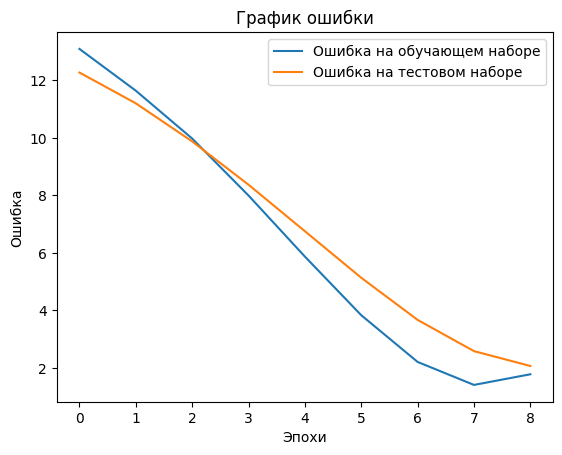

In [19]:
plt.plot(losses, label='Ошибка на обучающем наборе')
plt.plot(test_losses, label='Ошибка на тестовом наборе')

# Добавление заголовка и подписей осей
plt.title('График ошибки')
plt.xlabel('Эпохи')
plt.ylabel('Ошибка')

# Добавление легенды
plt.legend()

# Показать график
plt.show()

## Видно, что модель неплохо обучалась, но скорее всего неудачно была выбрана точка старта градиентного спуска, смоделируем еще несколько заупсков на 20 эпох и сохраним веса лучшей модели

In [20]:
def params_chose(data_set, model, optimizer, criterion, min_loss, epochs, l, best_lr):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(data_set)
        loss = criterion(output.view(-1), y_tr)

        loss.backward()
        
        optimizer.step()
        
        losses.append(loss.item())
        if get_preds(model, test_data, y_te)<min_loss:
            min_loss = get_preds(model, test_data, y_te)
            best_lr = l
            print("new best test loss!", min_loss)
            torch.save(model.state_dict(), 'model_weights.pth')
    return min_loss, best_lr
        

In [21]:
min_loss = 1e9
best_lr = 0 
for _ in trange(15):
    for l in [0.0009, 0.0005, 0.0003, 0.0002, 0.0001]:
        model = GNN(num_features=data_set.x.size(1))
        optimizer = optim.Adam(model.parameters(), lr=l)
        criterion = nn.MSELoss()
        min_loss, best_lr = params_chose(data_set, model, optimizer, criterion,min_loss, 20, l, best_lr)

  0%|          | 0/15 [00:00<?, ?it/s]

new best test loss! 13.65408992767334
new best test loss! 12.371654510498047
new best test loss! 10.630976676940918
new best test loss! 8.507401466369629
new best test loss! 6.094858169555664
new best test loss! 3.8046138286590576
new best test loss! 2.3374929428100586
new best test loss! 2.0251054763793945
new best test loss! 1.9999297857284546
new best test loss! 1.9327164888381958
new best test loss! 1.8841629028320312


In [22]:
model = GNN(num_features=data_set.x.size(1))

model.load_state_dict(torch.load('model_weights.pth'))

C:\Users\Александр\AppData\Local\Temp\ipykernel_13132\3392643588.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_weights.pth'))


<All keys matched successfully>

In [23]:
get_preds(model, test_data, y_te)

1.8841629028320312

# Подведем итоги проекта:
1. Удалось построить GCN для задачи рекомендательной системы фильмов
2. С помощью эффективного подбора гиппер-параметров и многократных запусков удалось получить достаточно низкую MSE на тестовой выборке:
3. Модель может предсказать оценку для ЛЮБОГО польовтеля и любого фильма из данного набора данных, то есть уже сейчас модель может использоваться для выдачи рекомендаций самым активным пользователям.